## AQI Index Prediction : A Comparative Study

$\text{AQI} = \text{I\_low} + \left( \frac{\text{I\_hi} - \text{I\_low}}{\text{C\_hi} - \text{C\_low}} \right) \times (\text{C} - \text{C\_low})
$

- AQI is the Air Quality Index.
- I_hi is the AQI value corresponding to the higher concentration breakpoint.
- I_low is the AQI value corresponding to the lower concentration breakpoint.
- C_hi is the concentration value corresponding to the higher concentration breakpoint.
- C_low is the concentration value corresponding to the lower concentration breakpoint.
- C is the concentration of the pollutant.

#### Loading dataset and performing EDA

In [1]:
# Importing libraries
import tensorflow as tf
from tensorflow import keras 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

# Suppressing warnings
warnings.simplefilter("ignore")

In [2]:
# Load the data
station_day = pd.read_csv("station_day.csv")

In [3]:
# Display the first few rows of the dataframe
station_day.head()

StationId        Date  PM2.5    PM10    NO    NO2    NOx    NH3    CO  \
0     AP001  24-11-2017  71.36  115.75  1.75  20.65  12.40  12.19  0.10   
1     AP001  25-11-2017  81.40  124.50  1.44  20.50  12.08  10.72  0.12   
2     AP001  26-11-2017  78.32  129.06  1.26  26.00  14.85  10.28  0.14   
3     AP001  27-11-2017  88.76  135.32  6.60  30.85  21.77  12.91  0.11   
4     AP001  28-11-2017  64.18  104.09  2.56  28.07  17.01  11.42  0.09   

     SO2      O3  Benzene  Toluene  Xylene    AQI AQI_Bucket  
0  10.76  109.26     0.17     5.92    0.10    NaN        NaN  
1  15.24  127.09     0.20     6.50    0.06  184.0   Moderate  
2  26.96  117.44     0.22     7.95    0.08  197.0   Moderate  
3  33.59  111.81     0.29     7.63    0.12  198.0   Moderate  
4  19.00  138.18     0.17     5.02    0.07  188.0   Moderate

In [4]:
# Display information about the dataframe
station_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108035 entries, 0 to 108034
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   StationId   108035 non-null  object 
 1   Date        108035 non-null  object 
 2   PM2.5       86410 non-null   float64
 3   PM10        65329 non-null   float64
 4   NO          90929 non-null   float64
 5   NO2         91488 non-null   float64
 6   NOx         92535 non-null   float64
 7   NH3         59930 non-null   float64
 8   CO          95037 non-null   float64
 9   SO2         82831 non-null   float64
 10  O3          82467 non-null   float64
 11  Benzene     76580 non-null   float64
 12  Toluene     69333 non-null   float64
 13  Xylene      22898 non-null   float64
 14  AQI         87025 non-null   float64
 15  AQI_Bucket  87025 non-null   object 
dtypes: float64(13), object(3)
memory usage: 13.2+ MB


In [5]:
# Check the shape of the dataframe
station_day.shape

(108035, 16)

In [6]:
# Check for missing values
station_day.isnull().sum()

StationId         0
Date              0
PM2.5         21625
PM10          42706
NO            17106
NO2           16547
NOx           15500
NH3           48105
CO            12998
SO2           25204
O3            25568
Benzene       31455
Toluene       38702
Xylene        85137
AQI           21010
AQI_Bucket    21010
dtype: int64

In [7]:
# Drop rows with missing values
station_day_cleaned = station_day.dropna()

In [8]:
# Check the shape of the cleaned dataframe
station_day_cleaned.shape

(10314, 16)

#### Various Plots of the data

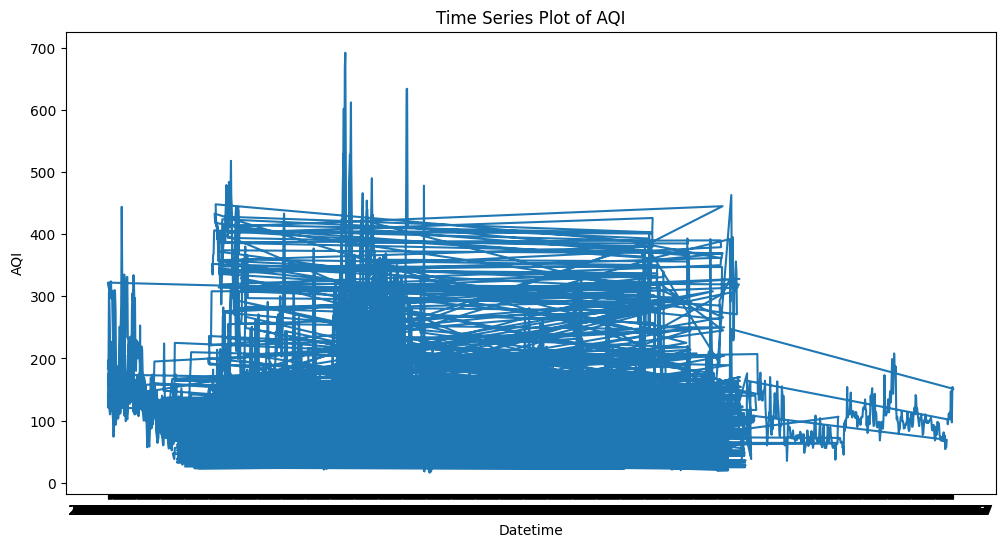

In [9]:
# Timeseries plot of AQI
plt.figure(figsize=(12, 6))
plt.plot(station_day_cleaned['Date'], station_day_cleaned['AQI'])
plt.title('Time Series Plot of AQI')
plt.xlabel('Datetime')
plt.ylabel('AQI')
plt.show()

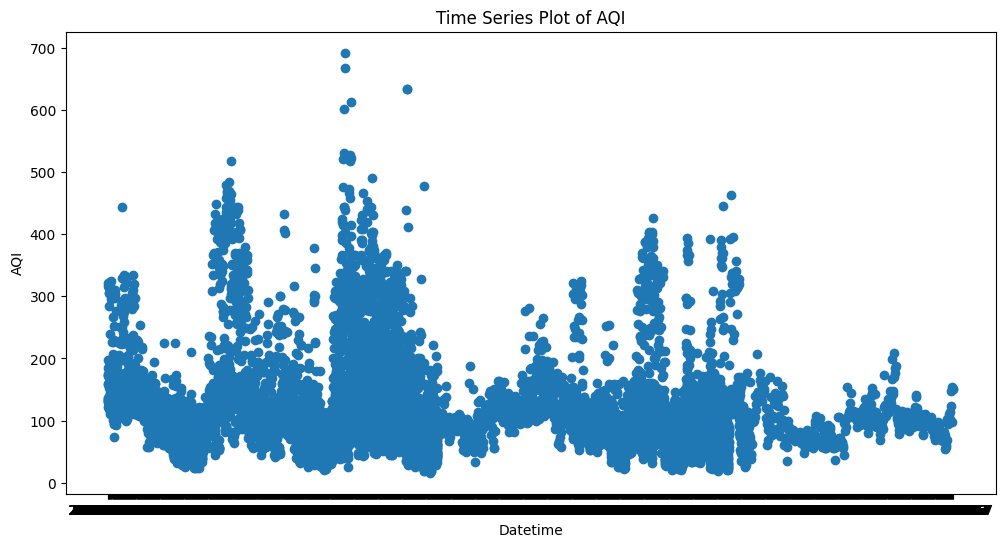

In [10]:
plt.figure(figsize=(12, 6))
plt.scatter(station_day_cleaned['Date'], station_day_cleaned['AQI'])
plt.title('Time Series Plot of AQI')
plt.xlabel('Datetime')
plt.ylabel('AQI')
plt.show()

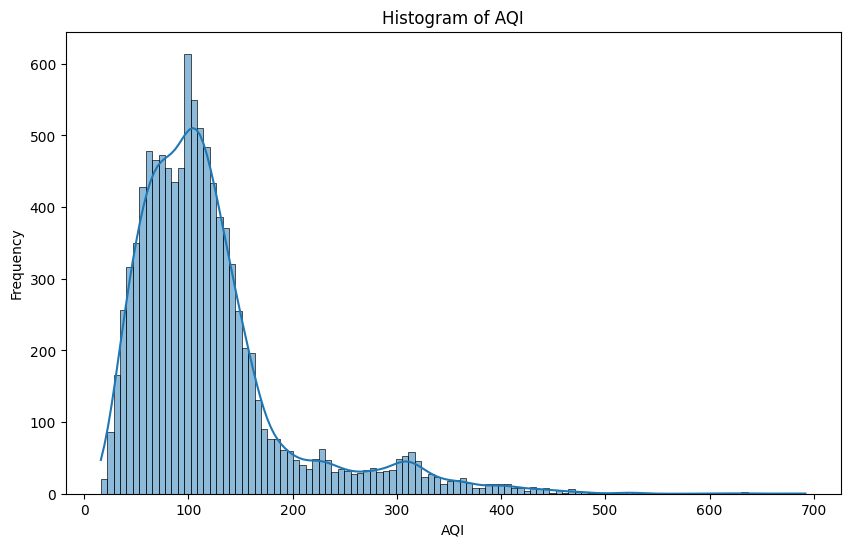

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(station_day_cleaned['AQI'], kde=True)
plt.title('Histogram of AQI')
plt.xlabel('AQI')
plt.ylabel('Frequency')
plt.show()

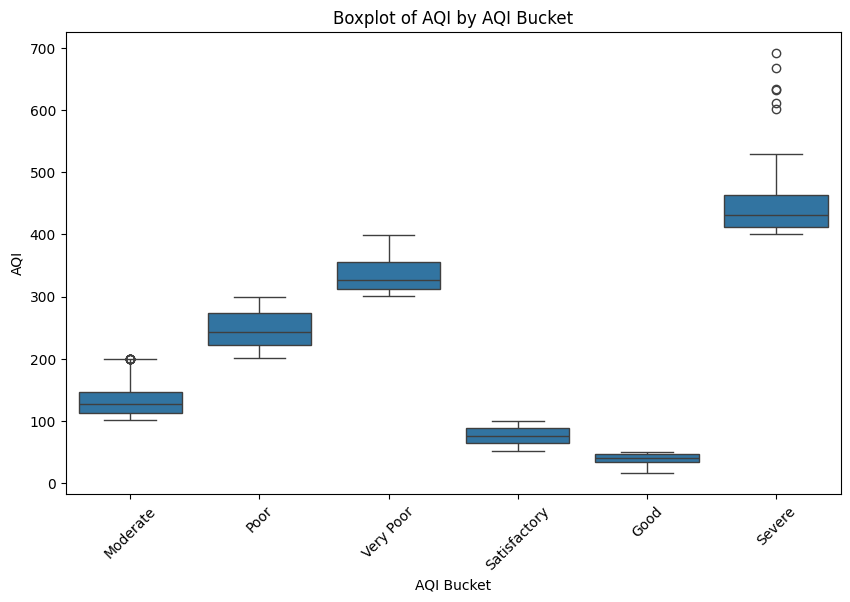

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='AQI_Bucket', y='AQI', data=station_day_cleaned)
plt.title('Boxplot of AQI by AQI Bucket')
plt.xlabel('AQI Bucket')
plt.ylabel('AQI')
plt.xticks(rotation=45)
plt.show()

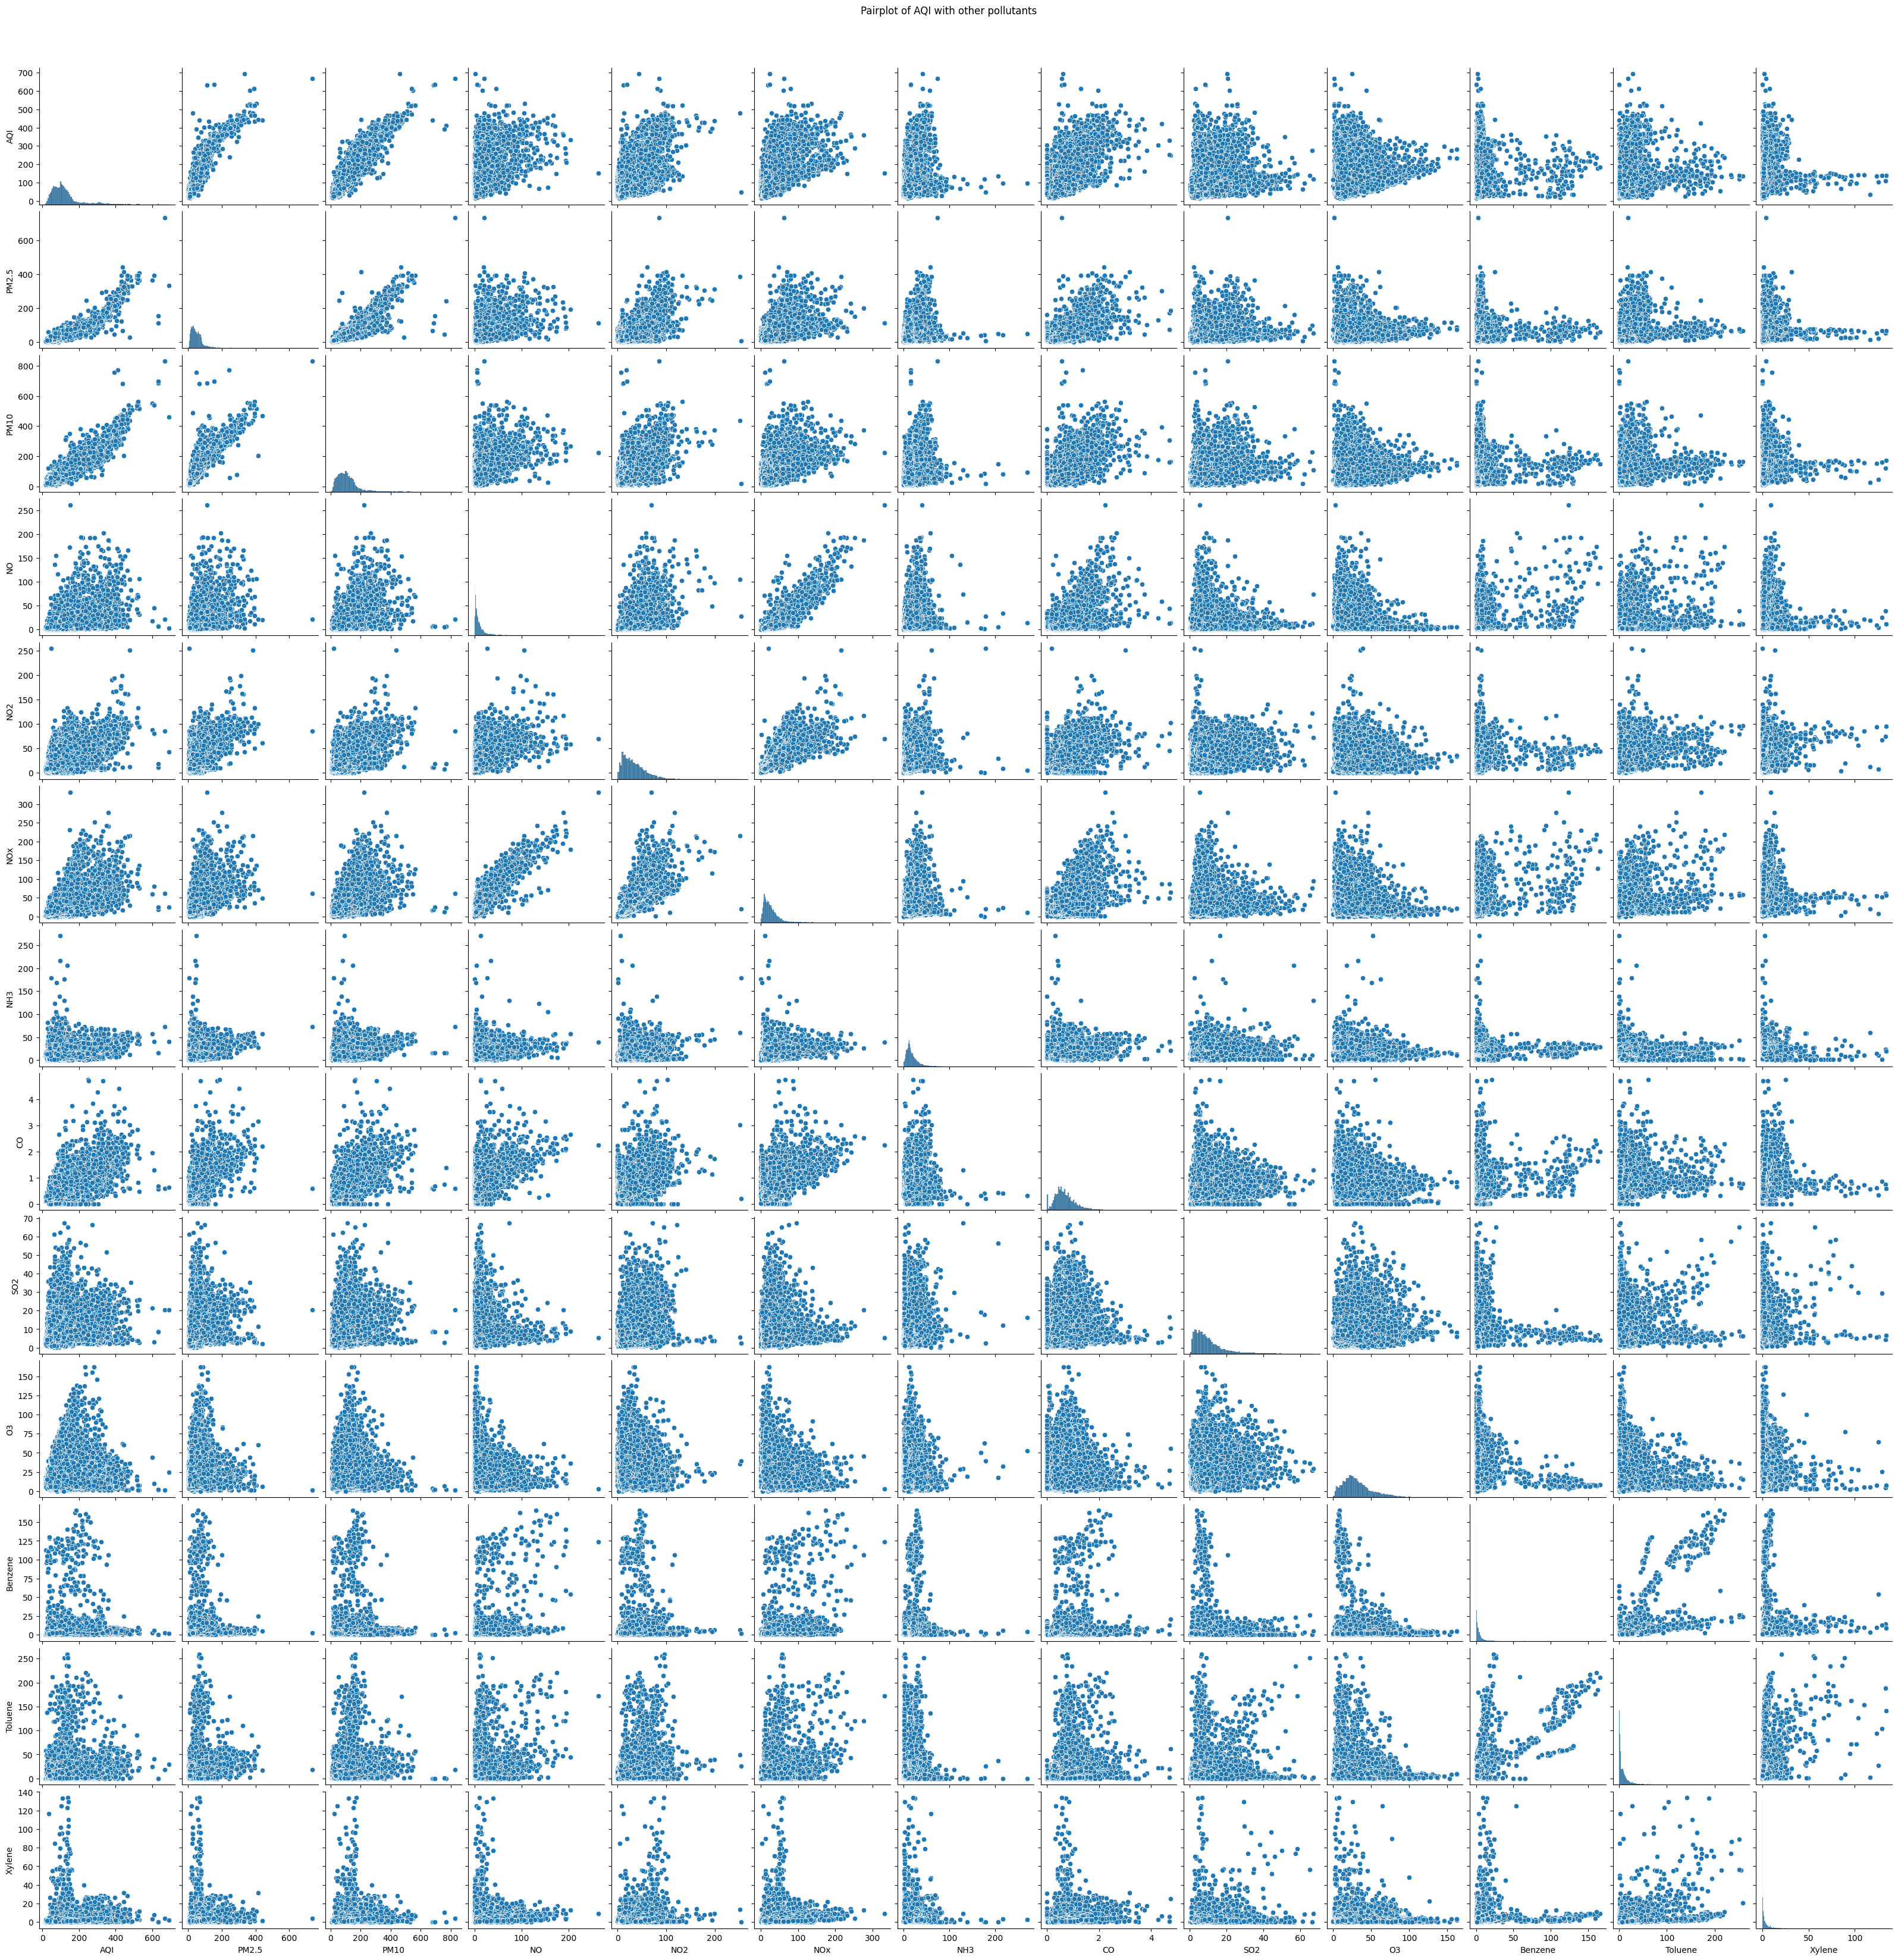

In [13]:
pollutants = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']
sns.pairplot(station_day_cleaned, vars=['AQI'] + pollutants)
plt.suptitle('Pairplot of AQI with other pollutants', y=1.02)
plt.show()

### ARIMA

$Y_t = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \cdots + \phi_p Y_{t-p} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q} + \epsilon_t
$

The ARIMA model is denoted as ARIMA (p,d,q), where:
- Y_t       : Value of the time series at time t
- c         : Constant or drift term
- phi_1...phi_p : Autoregressive parameters of the model
- theta_1...theta_q : Moving average parameters of the model
- epsilon_t : Error term at time t, assumed to be white noise with mean zero and constant variance
- p         : Order of the autoregressive component
- d         : Degree of differencing
- q         : Order of the moving average component

In [14]:
# Import libraries for ARIMA
from statsmodels.tsa.arima.model import ARIMA
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [15]:
# Extract relevant columns for ARIMA
arima_df = station_day[['StationId', 'Date','AQI']]

In [16]:
# Convert the 'Date' column to datetime
arima_df["Date"]= pd.to_datetime(arima_df["Date"])

In [17]:
# Create a time series object by aggregating "AQI" values at a daily frequency
ts = arima_df.groupby(pd.PeriodIndex(arima_df['Date'], freq="D"))['AQI'].mean()
ts.shape

(2009,)

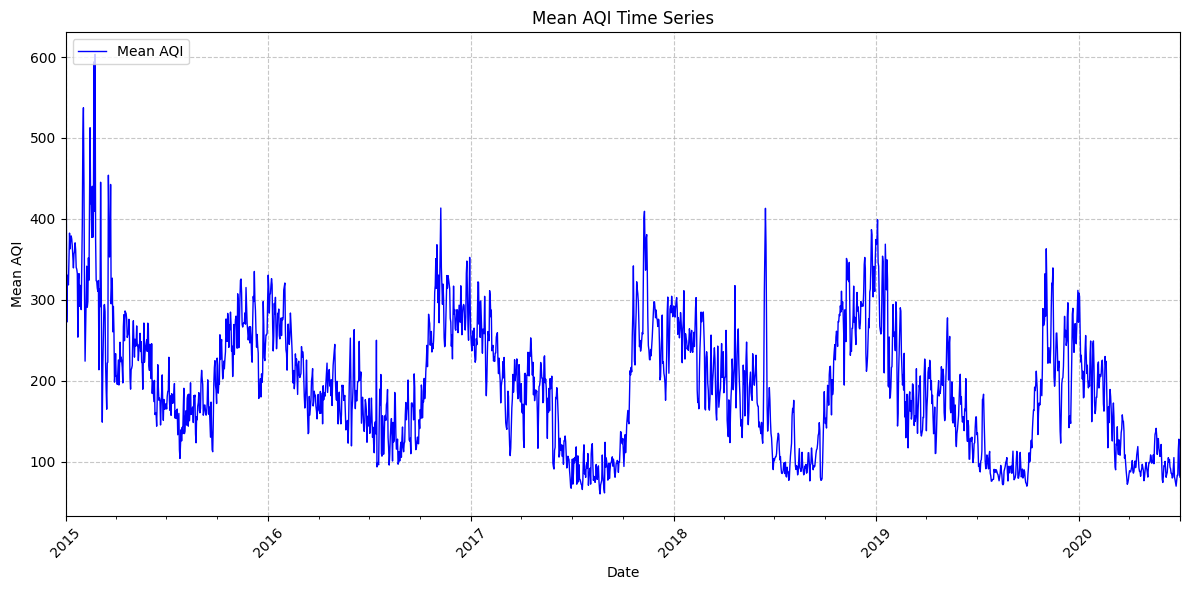

In [18]:
# Plot Mean AQI over time
fig, ax = plt.subplots(figsize=(12, 6))

ts.plot(ax=ax, color='blue', linestyle='-', linewidth=1)

ax.set_title('Mean AQI Time Series', fontsize=12)
ax.set_xlabel('Date', fontsize=10)
ax.set_ylabel('Mean AQI', fontsize=10)

ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(['Mean AQI'], loc='upper left', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

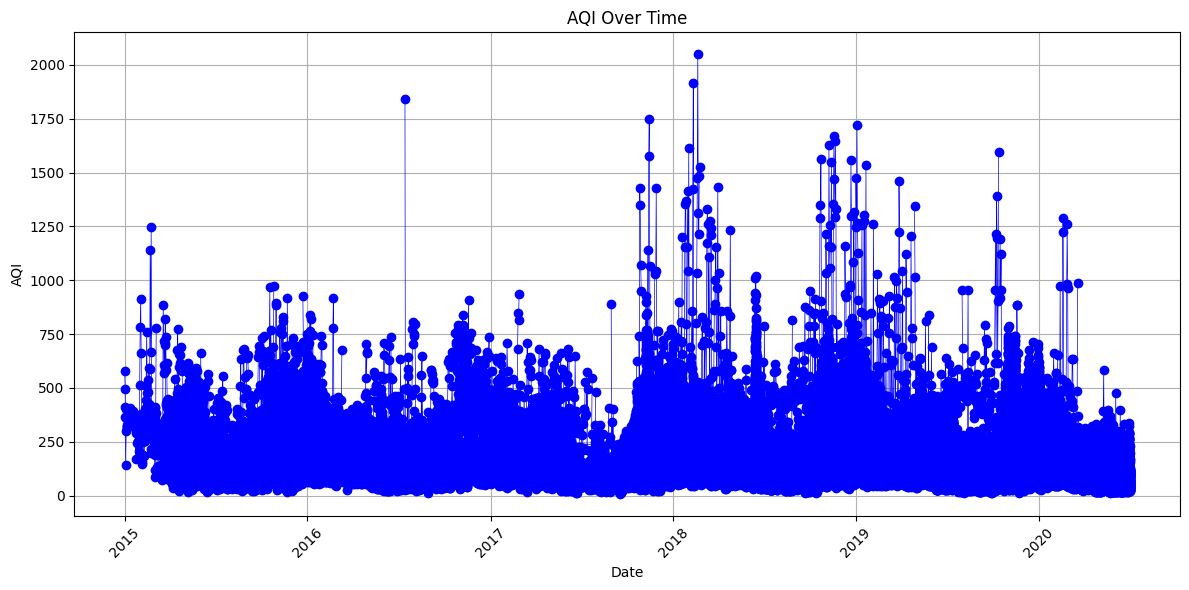

In [19]:
# Plot AQI over time
plt.figure(figsize=(12, 6))
plt.plot(arima_df['Date'], arima_df['AQI'], color='blue', marker='o', linestyle='-', linewidth='0.5')
plt.title('AQI Over Time')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

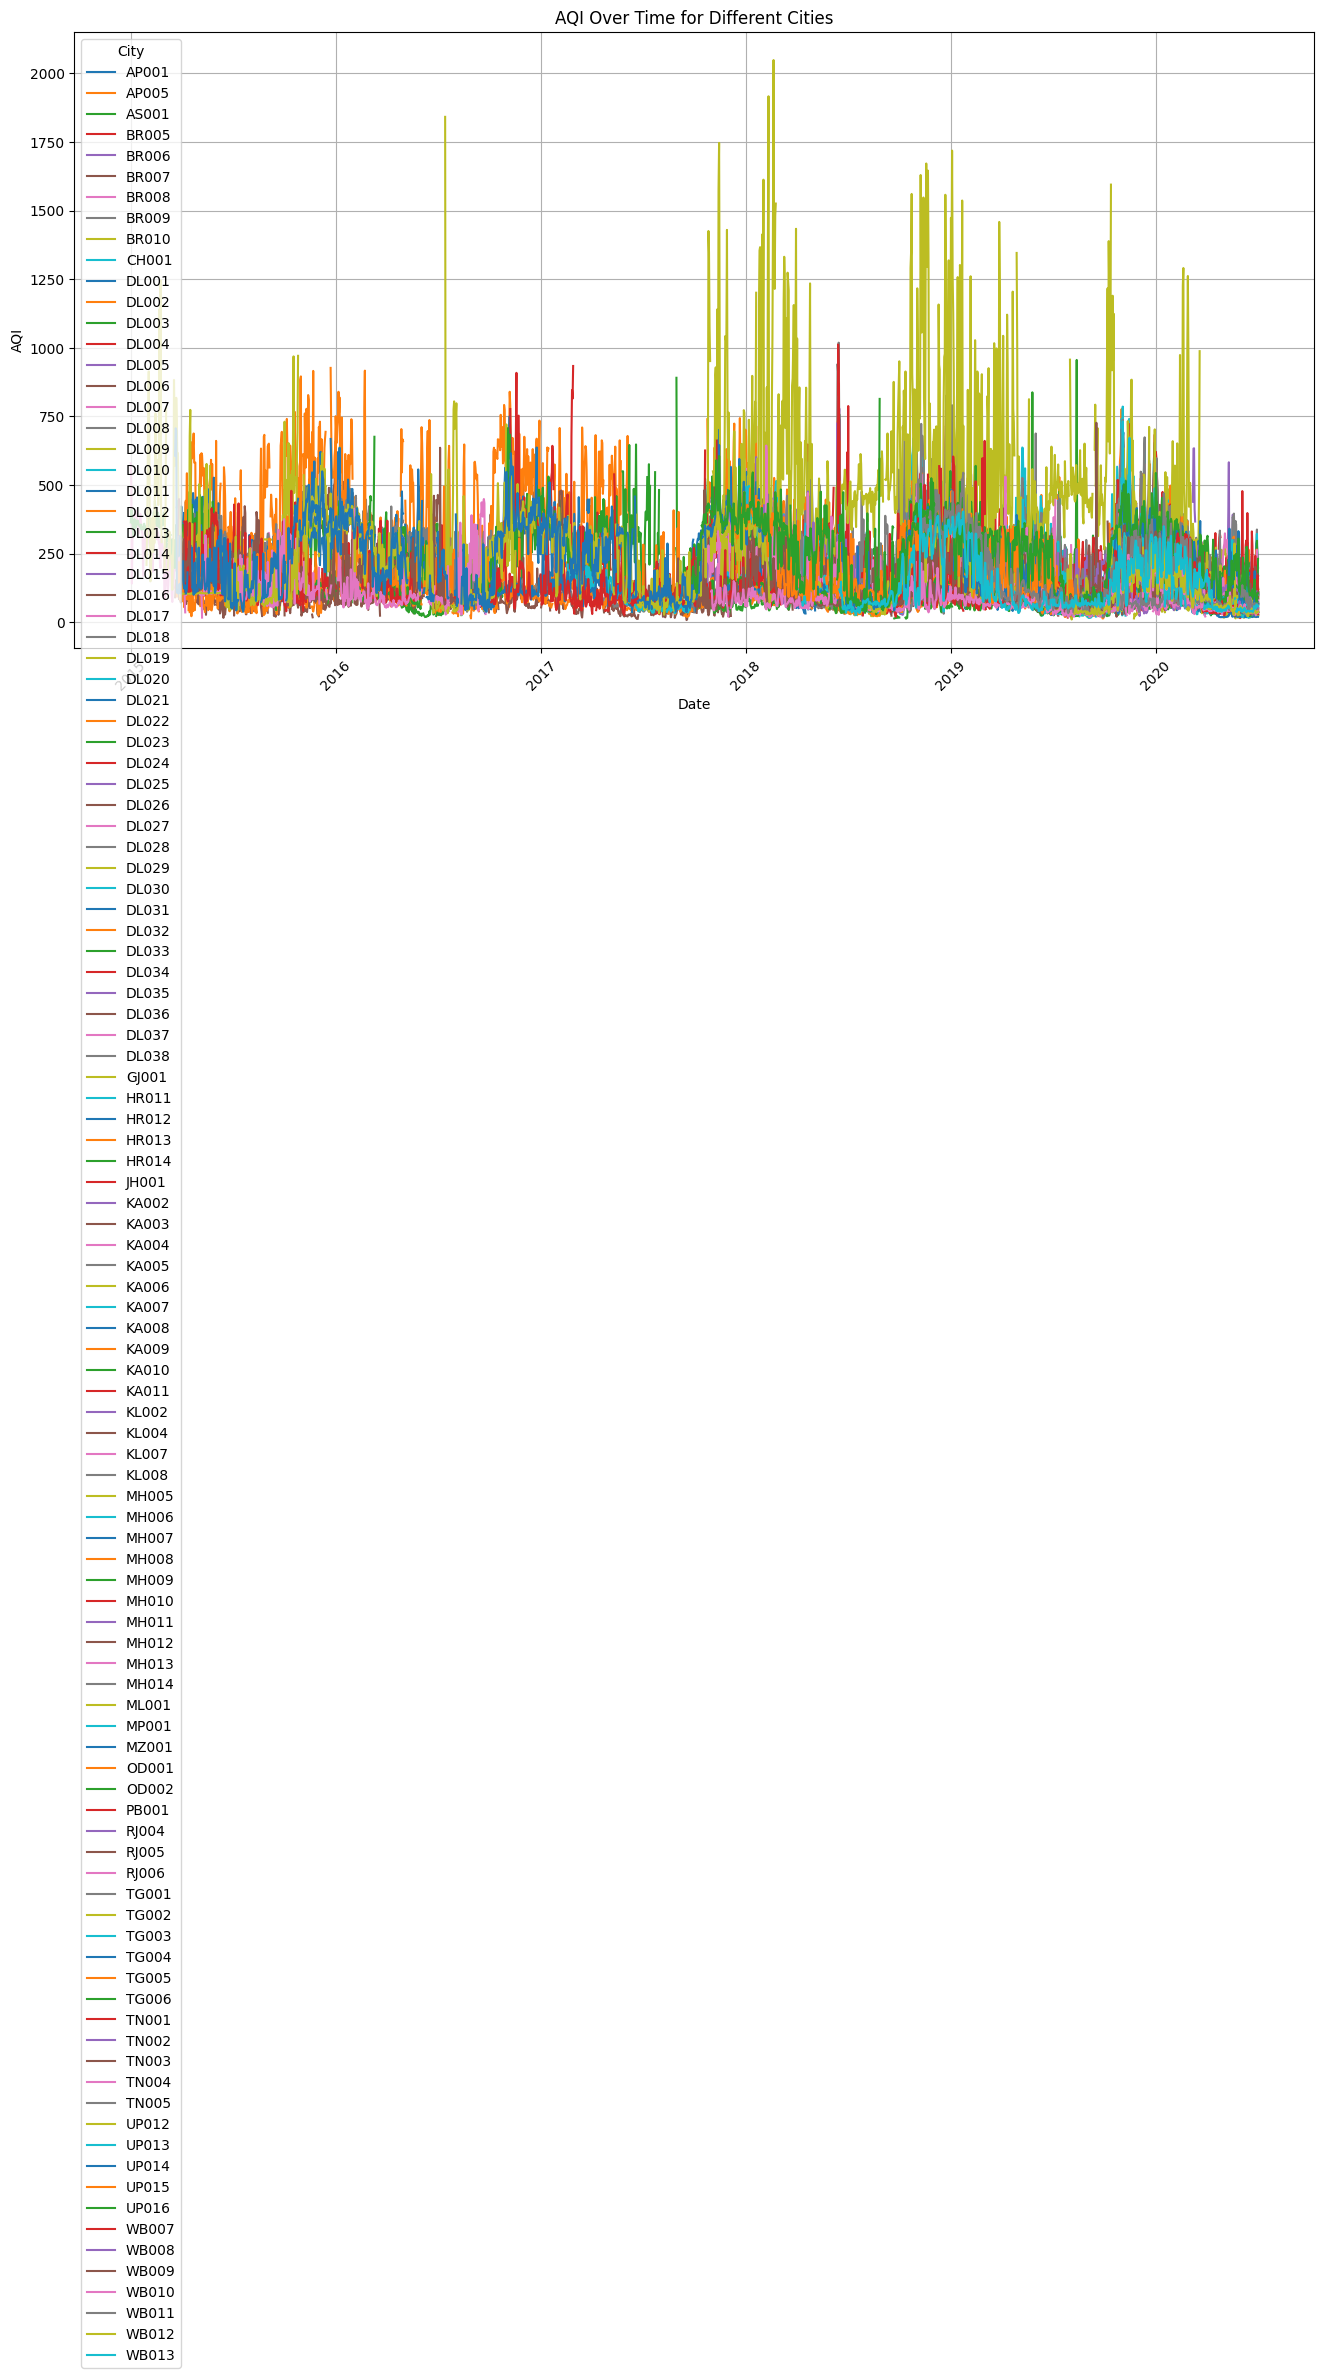

In [20]:
# Plot AQI for each city separately
plt.figure(figsize=(16, 8))
grouped_data = arima_df.groupby(['StationId', pd.Grouper(key='Date', freq='D')])['AQI'].mean().reset_index()
for station, data in grouped_data.groupby('StationId'):
    plt.plot(data['Date'], data['AQI'], label=station)
plt.title('AQI Over Time for Different Cities')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.xticks(rotation=45)
plt.legend(title='City')
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
# Group AQI data
ts = arima_df.groupby(pd.PeriodIndex(arima_df['Date'], freq="M"))['AQI'].mean()

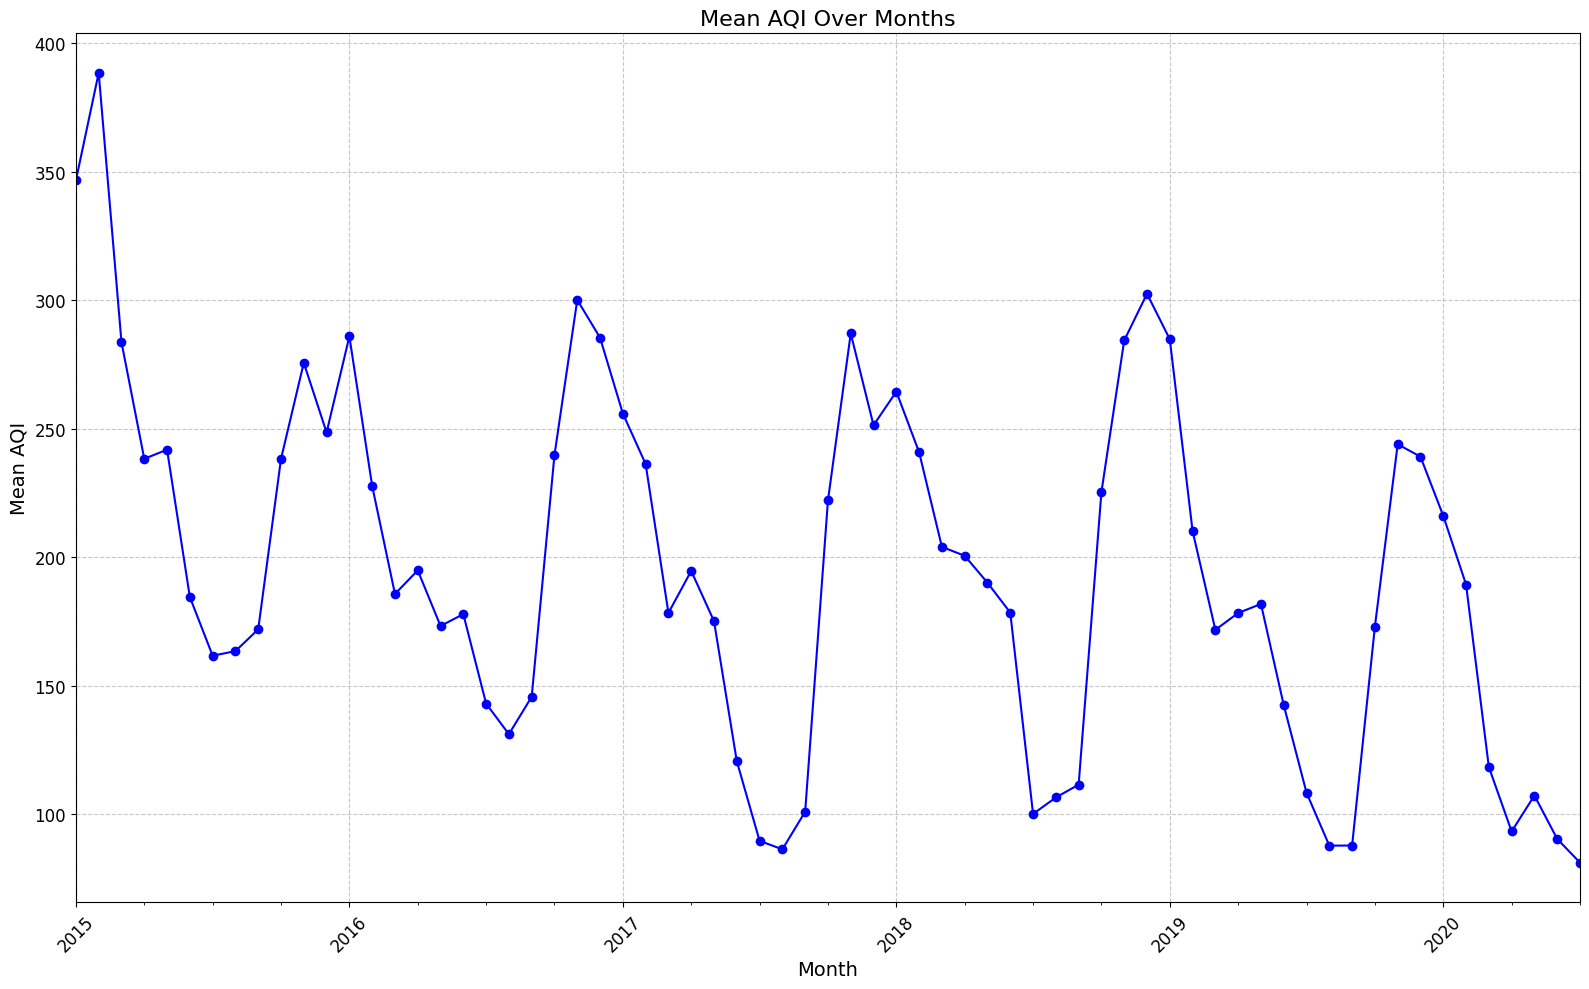

In [22]:
# Group AQI data by month and plot
plt.figure(figsize=(16, 10))
ts.plot(color='blue', marker='o', linestyle='-')

plt.title('Mean AQI Over Months', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Mean AQI', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

In [23]:
# Check stationarity of the time series using Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
result = adfuller(ts)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -1.224504674189465
p-value: 0.6629666021023679


Since p > 0.05, the data is not stationary

In [24]:
# Split data into training and testing sets
ts_train = ts[:50]
ts_test = ts[50:]

In [25]:
# Grid search for ARIMA parameters
p = range(0, 8)
q = range(0, 8)
d = range(0, 2)
pqd_combination = list(itertools.product(p, d, q))
error = []
pqd = []
for i in pqd_combination:
    A_model = ARIMA(ts_train, order=i).fit()
    predict = A_model.predict(len(ts_train), len(ts)-1)
    e = np.sqrt(mean_squared_error(ts_test, predict))
    pqd.append(i)
    error.append(e)

c:\Users\akshg\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\akshg\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\akshg\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\akshg\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

In [26]:
# Find the minimum error and corresponding parameters
min_error = min(error)
index = error.index(min_error)
best_pqd = pqd[index]
print(min_error, ' => ', best_pqd)

48.48382927506587  =>  (7, 1, 1)


In [27]:
# Fit ARIMA model to the entire training data with best parameters
model_ts = ARIMA(ts_train, order=best_pqd)
model_ts_fit = model_ts.fit()
print(model_ts_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    AQI   No. Observations:                   50
Model:                 ARIMA(7, 1, 1)   Log Likelihood                -241.966
Date:                Fri, 16 Feb 2024   AIC                            501.931
Time:                        02:42:55   BIC                            518.957
Sample:                    01-31-2015   HQIC                           508.391
                         - 02-28-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7066      0.217      3.257      0.001       0.281       1.132
ar.L2         -0.2553      0.247     -1.036      0.300      -0.739       0.228
ar.L3         -0.1310      0.188     -0.697      0.4

In [28]:
# Make predictions for the testing period
arima_predict = model_ts_fit.predict(start=len(ts_train), end=len(ts_train) + len(ts_test) - 1)
print(arima_predict)

2019-03    174.832141
2019-04    176.314917
2019-05    154.639002
2019-06    144.255605
2019-07    136.501187
2019-08    135.122332
2019-09    180.340895
2019-10    231.939662
2019-11    256.770887
2019-12    264.505766
2020-01    242.766815
2020-02    211.082086
2020-03    193.602124
2020-04    173.783580
2020-05    154.999405
2020-06    147.490616
2020-07    147.303021
Freq: M, Name: predicted_mean, dtype: float64


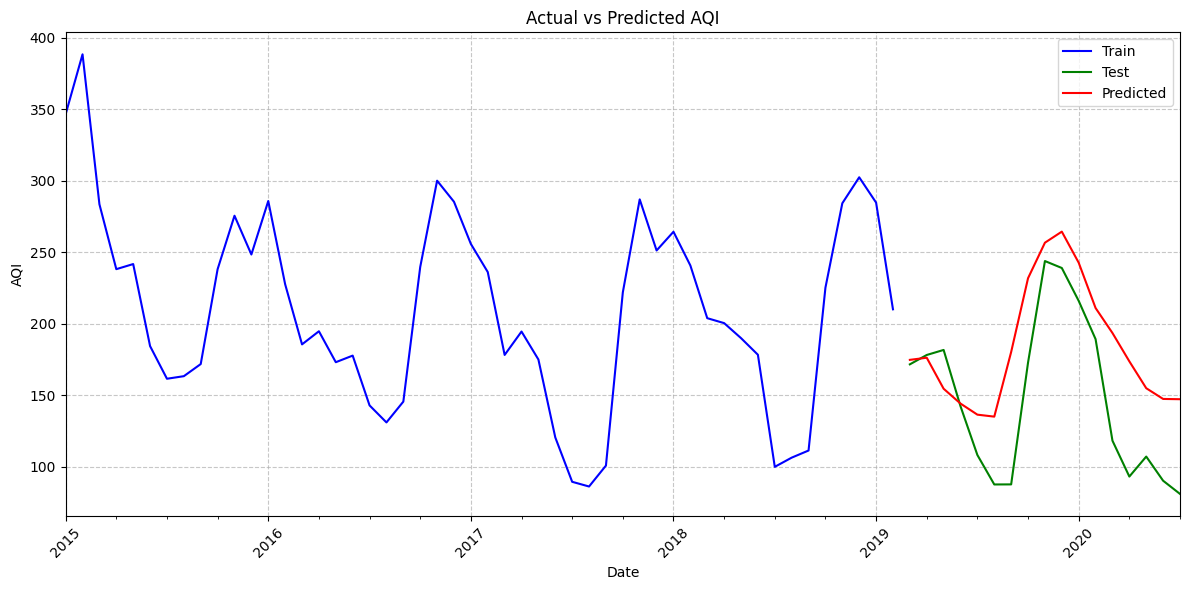

In [29]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))

# Plotting training data
ts_train.plot(label='Train', color='blue', linestyle='-')

# Plotting training data
ts_test.plot(label='Test', color='green', linestyle='-')

# Plotting predicted values
arima_predict.plot(label='Predicted', color='red', linestyle='-')

# Adding title and labels
plt.title('Actual vs Predicted AQI', fontsize=12)
plt.xlabel('Date', fontsize=10)
plt.ylabel('AQI', fontsize=10)

# Adding legend and grid
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Adjusting tick parameters
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=10)

# Showing plot
plt.tight_layout()
plt.show()


In [30]:
# Calculate evaluation metrics
def evaluate_arima_model(ts_test, arima_predict):
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(ts_test, arima_predict)
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(ts_test, arima_predict)
    
    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Calculate R-squared (R2) score
    r2 = r2_score(ts_test, arima_predict)
    
    return mae, mse, rmse, r2

# Call the function to evaluate the ARIMA model
mae, mse, rmse, r2 = evaluate_arima_model(ts_test, arima_predict)

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)


Mean Absolute Error (MAE): 39.715745479849105
Mean Squared Error (MSE): 2350.681701173735
Root Mean Squared Error (RMSE): 48.48382927506587
R-squared (R2) Score: 0.18968693610158127


### SARIMAX

$Y_t = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \cdots + \phi_p Y_{t-p} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q} + \epsilon_t +
\sum_{k=1}^{P} \Phi_k Y_{t-kS} + \sum_{k=1}^{Q} \Theta_k \epsilon_{t-kS}
$

- Y_t : Value of the time series at time t.
- c : Constant or drift term.
- φ₁, φ₂, ..., φₚ : Autoregressive parameters of the non-seasonal part of the model.
- θ₁, θ₂, ..., θ_q : Moving average parameters of the non-seasonal part of the model.
- ε_t : Error term at time t, assumed to be white noise with mean zero and constant variance.
- P : Order of the seasonal autoregressive component.
- Q : Order of the seasonal moving average component.
- Φₖ : Seasonal autoregressive parameters.
- Θₖ : Seasonal moving average parameters.
- S : Length of the seasonal cycle.


A SARIMA model can be tuned with two kinds of orders:

- (p,d,q) order, which refers to the order of the time series (similar to ARIMA which does not consider seasonality)
- (P,D,Q,M) seasonal order, which refers to the order of the seasonal component of the time series

- P represents the seasonal order of the Seasonal AutoRegressive (SAR) component, which captures the seasonal linear relationship between the current observation and its past values separated by a seasonal period s.

- D represents the seasonal order of differencing for seasonal stationarity.
- Q represents the seasonal order of the Seasonal Moving Average (SMA) component, which captures the seasonal linear relationship between the current observation and past white noise (residuals) separated by a seasonal period s.
- s represents the seasonal period or the number of months

In [31]:
# Check stationarity of the time series using Dickey-Fuller testp
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -1.224505
p-value                         0.662967
#Lags Used                     10.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


This time series is not stationary. Because P > 0.05 .So we want to take first differntioal for series

In [33]:
# Make the time series stationary
sarima_ts = ts - ts.shift(1)
sarima_ts=sarima_ts.dropna()

In [34]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(sarima_ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput )

Results of Dickey-Fuller Test:
Test Statistic                -7.389944e+00
p-value                        8.050075e-11
#Lags Used                     9.000000e+00
Number of Observations Used    5.600000e+01
Critical Value (1%)           -3.552928e+00
Critical Value (5%)           -2.914731e+00
Critical Value (10%)          -2.595137e+00
dtype: float64


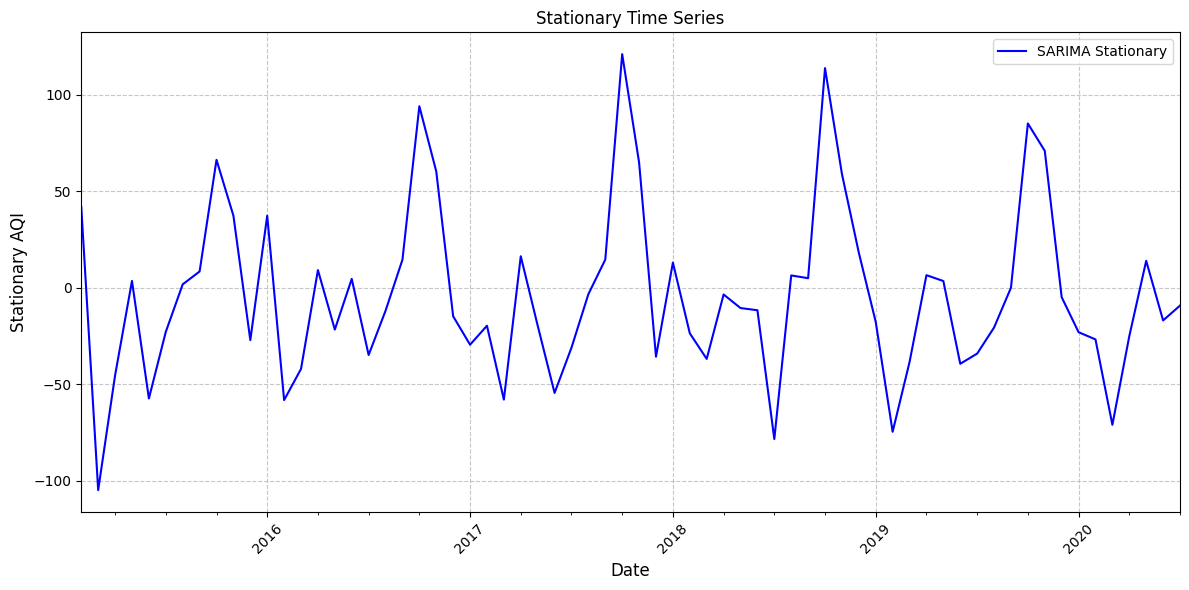

In [35]:
# Plot the stationary time series
plt.figure(figsize=(12, 6))

# Plotting the stationary time series
sarima_ts.plot(label='SARIMA Stationary', color='blue', linestyle='-')

# Adding title and labels
plt.title('Stationary Time Series', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stationary AQI', fontsize=12)

# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adjusting tick parameters
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend()

# Showing plot
plt.tight_layout()
plt.show()


In [36]:
# Split data into training and testing sets
sarima_ts_train = sarima_ts[:50]
sarima_ts_test = sarima_ts[50:]

In [37]:
# Grid search for SARIMA parameters
df_pdq = []
df_error = []

for i in pqd_combination:
    A_model = ARIMA(sarima_ts_train,order= i).fit()
    predict = A_model.predict(len(sarima_ts_train),len(sarima_ts)-1)
    e = np.sqrt(mean_squared_error(sarima_ts_test,predict))
    df_pdq.append(i)
    df_error.append(e)

c:\Users\akshg\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\akshg\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\akshg\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\akshg\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

In [38]:
# Find the minimum error and corresponding parameters
min = df_error[0]
index = 0
for i in range(1,len(df_error)-1):
    if(min > df_error[i]):
        min = df_error[i]
        index = i
        
print(df_error[index],' => ',df_pdq[index])

20.38738070808806  =>  (7, 0, 3)


In [39]:
# Fit SARIMA model with best parameters
import statsmodels.api as sm
sarima_model = sm.tsa.statespace.SARIMAX(sarima_ts_train, trend='n', order=(7,0,3), seasonal_order=(1,1,1,12))
sarima_results = sarima_model.fit()
print(sarima_results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  AQI   No. Observations:                   50
Model:             SARIMAX(7, 0, 3)x(1, 1, [1], 12)   Log Likelihood                -176.686
Date:                              Fri, 16 Feb 2024   AIC                            379.373
Time:                                      02:43:39   BIC                            400.661
Sample:                                  02-28-2015   HQIC                           386.947
                                       - 03-31-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0910      2.144      0.042      0.966      -4.112       4.294
ar.L2         -0.99

c:\Users\akshg\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [40]:
# Make predictions for the testing period
sarima_predict = sarima_results.predict(start=len(sarima_ts_train),end=len(sarima_ts)-1)

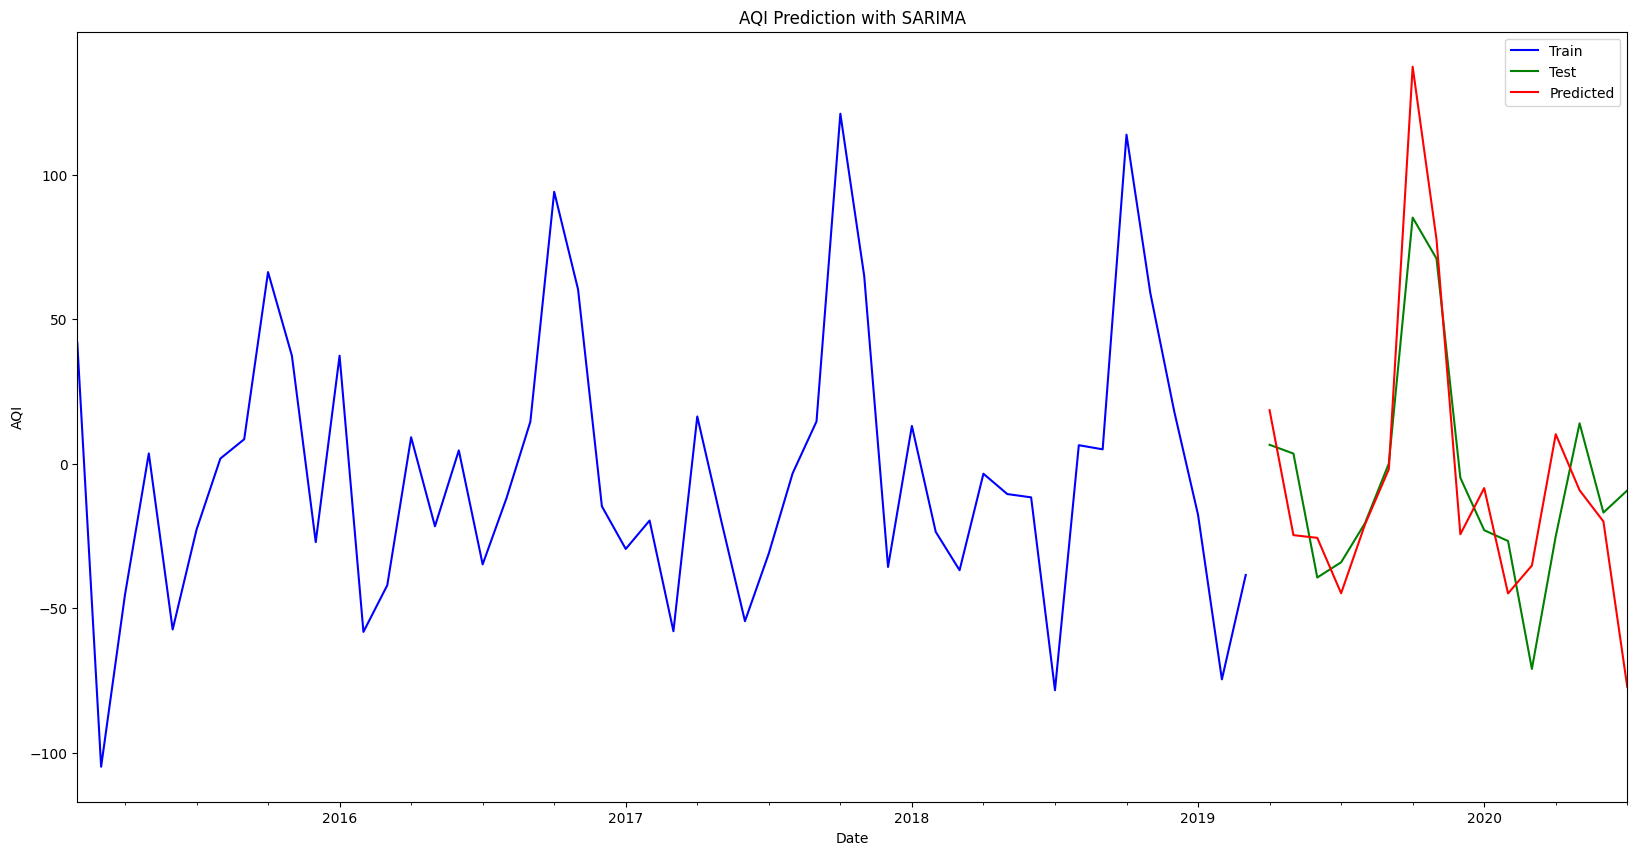

In [41]:
# Plot actual vs predicted values
plt.figure(figsize=(20, 10))

# Plotting training data
sarima_ts_train.plot(label='Train', color='blue')

# Plotting testing data
sarima_ts_test.plot(label='Test', color='green')

# Plotting predicted values
sarima_predict.plot(label='Predicted', color='red')

# Adding labels, legend, and title
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('AQI Prediction with SARIMA')
plt.legend()

plt.show()

In [42]:
# Calculate evaluation metrics
def evaluate_sarima_model(df1_ts_test, s_pred):
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(df1_ts_test, s_pred)
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(df1_ts_test, s_pred)
    
    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Calculate R-squared (R2) score
    r2 = r2_score(df1_ts_test, s_pred)
    
    return mae, mse, rmse, r2

# Call the function to evaluate the sarima model
mae, mse, rmse, r2 = evaluate_sarima_model(sarima_ts_test, sarima_predict)

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)

Mean Absolute Error (MAE): 21.478994274289533
Mean Squared Error (MSE): 790.6861381009726
Root Mean Squared Error (RMSE): 28.119141845030985
R-squared (R2) Score: 0.4375236059309152


### LSTM

\begin{align*}
i_t &= \sigma(W_{xi}x_t + W_{hi}h_{t-1} + W_{ci}c_{t-1} + b_i) \\
f_t &= \sigma(W_{xf}x_t + W_{hf}h_{t-1} + W_{cf}c_{t-1} + b_f) \\
g_t &= \tanh(W_{xg}x_t + W_{hg}h_{t-1} + b_g) \\
c_t &= f_t \odot c_{t-1} + i_t \odot g_t \\
o_t &= \sigma(W_{xo}x_t + W_{ho}h_{t-1} + W_{co}c_t + b_o) \\
h_t &= o_t \odot \tanh(c_t)
\end{align*}


- x_t : Input at time step t.
- h_t : Output (hidden state) at time step t.
- c_t : Cell state at time step t.
- i_t : Input gate at time step t.
- f_t : Forget gate at time step t.
- g_t : Cell input activation vector at time step t.
- o_t : Output gate at time step t.
- W_{xi}, W_{xf}, W_{xg}, W_{xo} : Weight matrices for input gates.
- W_{hi}, W_{hf}, W_{hg}, W_{ho} : Weight matrices for recurrent connections.
- W_{ci}, W_{cf}, W_{co} : Weight matrices for cell state connections.
- b_i, b_f, b_g, b_o : Bias vectors.
- σ : Sigmoid activation function.
- ⊙ : Element-wise multiplication.
- tanh : Hyperbolic tangent activation function.

In [43]:
# Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

In [44]:
# Load the data
lstm_df = pd.read_csv("station_day.csv")

In [45]:
# Convert the 'Date' column to datetime
lstm_df["Date"]= pd.to_datetime(lstm_df["Date"])

In [46]:
# Drop columns that are not required
lstm_df.drop(['AQI_Bucket', 'StationId'], axis=1, inplace=True)

In [47]:
# Drop empty rows
df_cleaned=lstm_df.dropna()
df_cleaned.shape

(10314, 14)

In [48]:
# Display information about the dataframe
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10314 entries, 1 to 106147
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     10314 non-null  datetime64[ns]
 1   PM2.5    10314 non-null  float64       
 2   PM10     10314 non-null  float64       
 3   NO       10314 non-null  float64       
 4   NO2      10314 non-null  float64       
 5   NOx      10314 non-null  float64       
 6   NH3      10314 non-null  float64       
 7   CO       10314 non-null  float64       
 8   SO2      10314 non-null  float64       
 9   O3       10314 non-null  float64       
 10  Benzene  10314 non-null  float64       
 11  Toluene  10314 non-null  float64       
 12  Xylene   10314 non-null  float64       
 13  AQI      10314 non-null  float64       
dtypes: datetime64[ns](1), float64(13)
memory usage: 1.2 MB


In [49]:
# Split data into train and test sets
train_size = int(len(df_cleaned) * 0.8)
train, test = df_cleaned[:train_size], df_cleaned[train_size:]

In [50]:
# Scaling data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_cleaned['AQI'].values.reshape(-1,1))
seq_length = 10

In [51]:
# Define function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, seq_length)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [52]:
# Define LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

In [53]:
# Training LSTM model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_lstm.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)
predictions_lstm = model_lstm.predict(X_test)
predictions_lstm = scaler.inverse_transform(predictions_lstm).flatten()
y_test = scaler.inverse_transform(y_test).flatten()

Epoch 1/100
207/207 [==============================] - 4s 10ms/step - loss: 0.0095 - val_loss: 0.0012
Epoch 2/100
207/207 [==============================] - 2s 8ms/step - loss: 0.0040 - val_loss: 0.0011
Epoch 3/100
207/207 [==============================] - 2s 8ms/step - loss: 0.0036 - val_loss: 9.9277e-04
Epoch 4/100
207/207 [==============================] - 2s 10ms/step - loss: 0.0033 - val_loss: 9.1518e-04
Epoch 5/100
207/207 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 8.5389e-04
Epoch 6/100
207/207 [==============================] - 1s 7ms/step - loss: 0.0028 - val_loss: 8.8100e-04
Epoch 7/100
207/207 [==============================] - 1s 7ms/step - loss: 0.0027 - val_loss: 8.1876e-04
Epoch 8/100
207/207 [==============================] - 2s 7ms/step - loss: 0.0027 - val_loss: 7.9549e-04
Epoch 9/100
207/207 [==============================] - 1s 7ms/step - loss: 0.0026 - val_loss: 7.8578e-04
Epoch 10/100
207/207 [==============================] - 2s 7m

In [54]:
# Calculate evaluation metrics
rmse_lstm = sqrt(mean_squared_error(y_test, predictions_lstm))
mse_lstm = mean_squared_error(y_test, predictions_lstm)
mae_lstm = mean_absolute_error(y_test, predictions_lstm)
r2_lstm = r2_score(y_test, predictions_lstm)

print('LSTM RMSE:', rmse_lstm)
print('LSTM MSE:', mse_lstm)
print('LSTM MAE:', mae_lstm)
print('LSTM R2 Score:', r2_lstm)

LSTM RMSE: 29.991592629290047
LSTM MSE: 899.4956284412851
LSTM MAE: 18.98771157894144
LSTM R2 Score: 0.8101528917870433


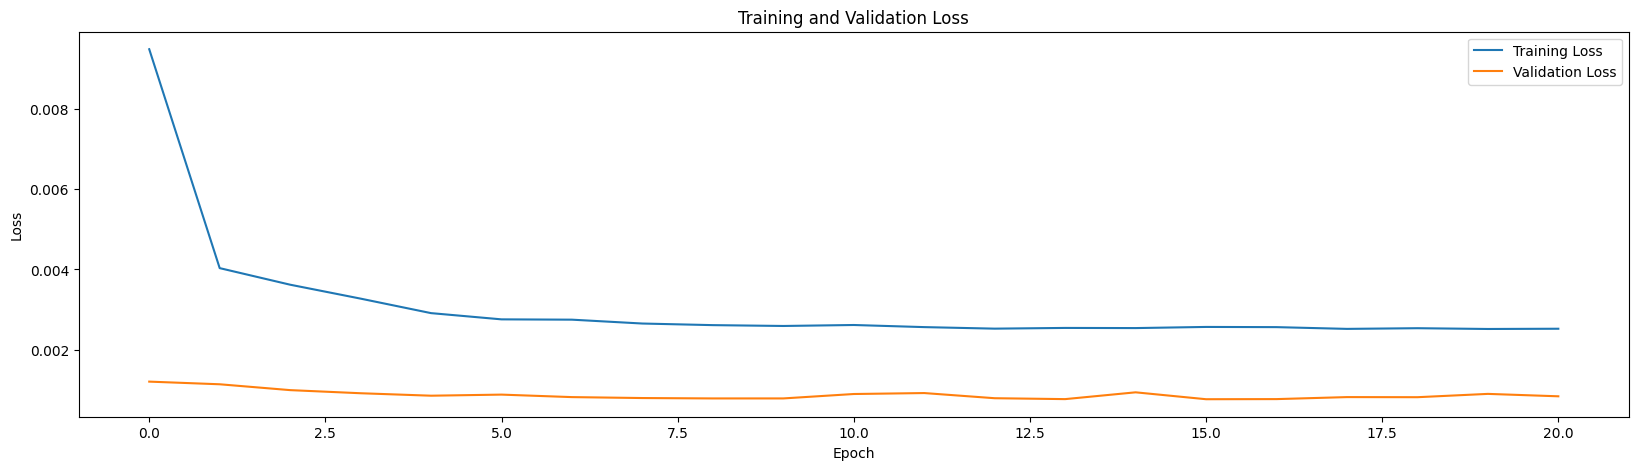

In [55]:
# Plotting training and validation loss
plt.figure(figsize=(20, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

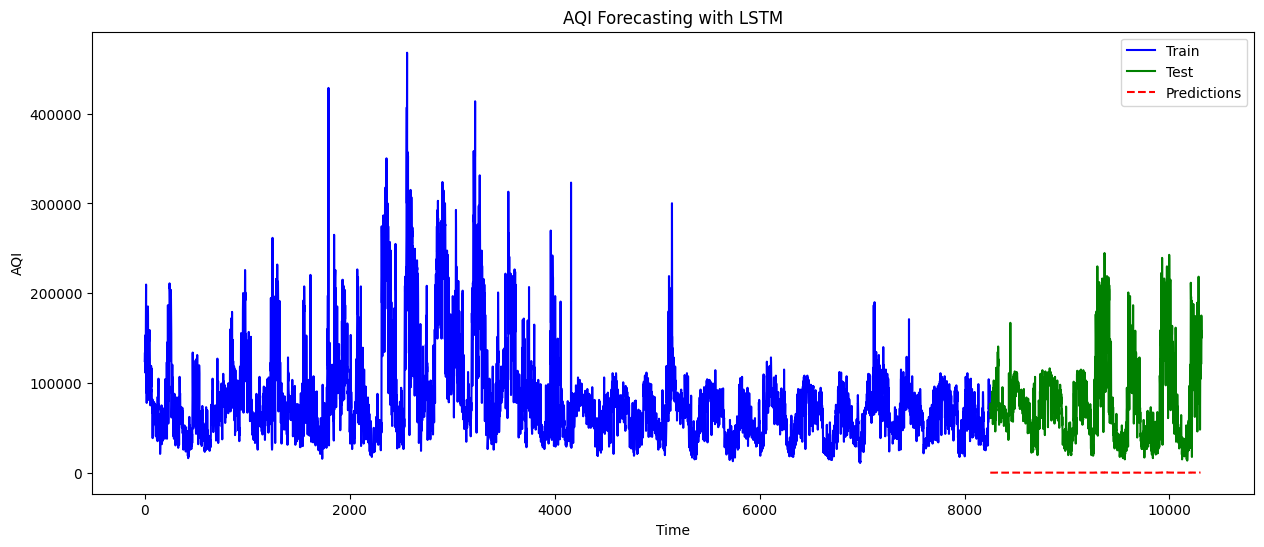

In [56]:
# Plot actual train, test, and predicted values
plt.figure(figsize=(15, 6))

# Plot training data
plt.plot(np.arange(0, len(train)), scaler.inverse_transform(train['AQI'].values.reshape(-1,1)), color='blue', label='Train')

# Plot testing data
plt.plot(np.arange(len(train), len(train) + len(test)), scaler.inverse_transform(test['AQI'].values.reshape(-1,1)), color='green', label='Test')

# Plot predicted values (aligned with test data)
plt.plot(np.arange(len(train), len(train) + len(predictions_lstm)), predictions_lstm, color='red', linestyle='--', label='Predictions')

plt.title('AQI Forecasting with LSTM')
plt.xlabel('Time')
plt.ylabel('AQI')
plt.legend()
plt.show()